In [1]:
import autograd.numpy as np  
from autograd import grad, elementwise_grad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn import datasets
from sklearn.datasets import make_blobs, load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from sklearn.neural_network import MLPClassifier

In [2]:
def plot_decision_boundary_nn(X, y, layers, activation_funcs, title="Decision Boundary of Neural Network"):
    # Create a mesh grid over the feature space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Flatten the grid to pass through the neural network
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict using the neural network
    Z = feed_forward_batch(grid, layers, activation_funcs)
    Z = np.argmax(Z, axis=1)  # Assuming binary classification, convert softmax output to class labels

    # Reshape Z to fit the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')  # Use contourf for filled contours
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0', alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1', alpha=0.7)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualization of the decision boundary
def plot_mlp_decision_boundary_scikit(X, y, model):
    # Create grid to plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Calculate decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

    # Scatter plot of training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='RdYlBu')
    plt.title("Decision Boundary of MLPClassifier and Data Points")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

def derivate(func):
    return elementwise_grad(func)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)
    
def binary_cross_entropy(predictions, targets):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)  # Avoid log(0)
    return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))

def binary_cross_entropy_der(predictions, targets):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)  # Avoid division by zero
    return (predictions - targets) / (predictions * (1 - predictions))

def r2_score(predictions, targets):
    ss_total = np.sum((targets - np.mean(targets)) ** 2)
    ss_residual = np.sum((targets - predictions) ** 2)
    return 1 - (ss_residual / ss_total)

def create_layers_batch(network_input_size, layer_output_sizes): 
    layers = []
    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(i_size, layer_output_size) * np.sqrt(2 / (i_size + layer_output_size))
        b = np.zeros(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers

def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = (a @ W) + b
        a = activation_func(z)
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = inputs  
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b  
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a 


def backpropagation_batched(input_batch, layers, activation_funcs, targets,activation_ders, cost_der):
    batch_size = input_batch.shape[0]
    layer_inputs, zs, predict = feed_forward_saver_batch(input_batch, layers, activation_funcs)
    layer_grads = [() for _ in layers]

    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]
        
        if i == len(layers) - 1:
            dC_da = cost_der(predict, targets)
        else:
            (W, b) = layers[i + 1][:2]
            dC_da = dC_dz @ W.T
        
        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz / batch_size
        dC_db = np.mean(dC_dz, axis=0)
        
        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

def train_nn_classification(inputs, targets, val_inputs, val_targets, layers, activation_funcs, activation_ders, learning_rate=0.001, epochs=100, batch_size=32):
    n_samples = len(inputs)
    training_metrics = {'loss': [], 'accuracy': []}
    validation_metrics = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs+1):
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]
        # Mini-batch training
        for i in range(0, n_samples, batch_size):
            batch_inputs = inputs_shuffled[i:i + batch_size]
            batch_targets = targets_shuffled[i:i + batch_size]
            # Compute gradients
            layer_grads = backpropagation_batched(batch_inputs, layers, activation_funcs, batch_targets, activation_ders, binary_cross_entropy_der)
            # Update weights and biases
            for j, ((W, b), (dW, db)) in enumerate(zip(layers, layer_grads)):
                layers[j] = (W - learning_rate * dW, b - learning_rate * db)
        
        if epoch % 100 == 0:
            predictions = feed_forward_batch(inputs, layers, activation_funcs)
            acc = accuracy_score(targets, (predictions > 0.5).astype(int))
            print(f'Epoch {epoch}, Training Accuracy: {acc:.4f}')
        
        # Calculate metrics on training set
        predictions_train = feed_forward_batch(inputs, layers, activation_funcs)
        loss_train = binary_cross_entropy(predictions_train, targets)
        accuracy_train = accuracy_score(targets, (predictions_train > 0.5).astype(int))
        training_metrics['loss'].append(loss_train)
        training_metrics['accuracy'].append(accuracy_train)

        # Calculate metrics on validation set
        predictions_val = feed_forward_batch(val_inputs, layers, activation_funcs)
        loss_val = binary_cross_entropy(predictions_val, val_targets)
        accuracy_val = accuracy_score(val_targets, (predictions_val > 0.5).astype(int))
        validation_metrics['loss'].append(loss_val)
        validation_metrics['accuracy'].append(accuracy_val)

    return layers, training_metrics, validation_metrics

# Perfectly separated classes

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(67)
# Generate synthetic data 
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=2, class_sep=2, random_state=42)


# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert y_train and y_test to one-hot encoding 
y_train_onehot = np.eye(2)[y_train]
y_val_onehot = np.eye(2)[y_val]

# Network configuration
input_size = X_train.shape[1]
layer_output_sizes = [8, 2]  # Output layer has 2 neurons for binary classification 
activation_funcs = [sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der]

# Create layers
layers = create_layers_batch(input_size, layer_output_sizes)

# Get initial predictions and accuracy
initial_predictions = feed_forward_batch(X_val, layers, activation_funcs)
initial_pred_classes = np.argmax(initial_predictions, axis=1)  # Convert to class labels
initial_acc = accuracy_score(y_val, initial_pred_classes)
print(f'Initial accuracy before training: {initial_acc:.4f}')

# Confusion matrix before training
initial_conf_matrix = confusion_matrix(y_val, initial_pred_classes)
print("\nConfusion Matrix before training on validation:")
print(initial_conf_matrix)

# Train the network
layers, training_metrics, validation_metrics = train_nn_classification(X_train, y_train_onehot, X_val, y_val_onehot, layers, activation_funcs, activation_ders, learning_rate=0.01, epochs=1000, batch_size=32)

# final predictions and accuracy
final_predictions = feed_forward_batch(X_val, layers, activation_funcs)
final_pred_classes = np.argmax(final_predictions, axis=1)  
final_acc = accuracy_score(y_val, final_pred_classes)
print(f'\nFinal accuracy after training on validation: {final_acc:.4f}')

# Confusion matrix after training
final_conf_matrix = confusion_matrix(y_val, final_pred_classes)
print("\nConfusion Matrix after training on validation:")
print(final_conf_matrix)

Initial accuracy before training: 0.1875

Confusion Matrix before training on validation:
[[3 5]
 [8 0]]
Epoch 0, Training Accuracy: 0.0000
Epoch 100, Training Accuracy: 0.4531
Epoch 200, Training Accuracy: 0.9688
Epoch 300, Training Accuracy: 0.9844
Epoch 400, Training Accuracy: 0.9844
Epoch 500, Training Accuracy: 0.9844
Epoch 600, Training Accuracy: 1.0000
Epoch 700, Training Accuracy: 1.0000
Epoch 800, Training Accuracy: 1.0000
Epoch 900, Training Accuracy: 1.0000
Epoch 1000, Training Accuracy: 1.0000

Final accuracy after training on validation: 1.0000

Confusion Matrix after training on validation:
[[8 0]
 [0 8]]


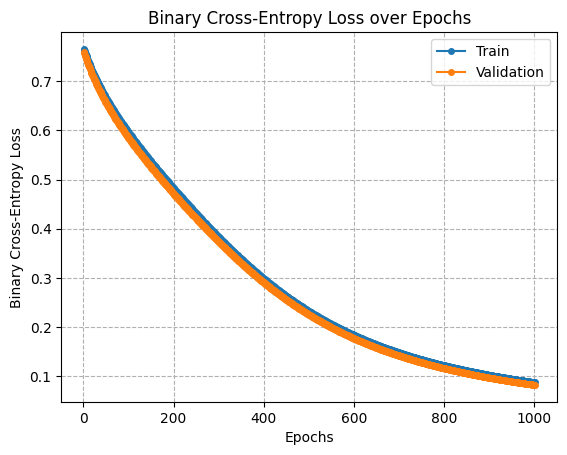

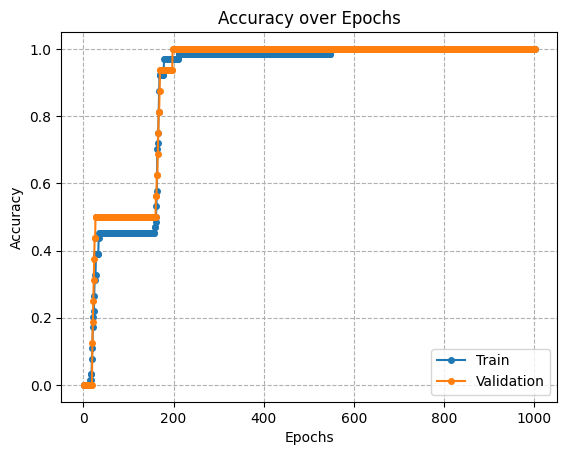

In [5]:
# Plot training and validation loss
plt.plot(range(1, len(training_metrics['loss']) + 1), training_metrics['loss'], label='Train', marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics['loss']) + 1), validation_metrics['loss'], label='Validation', marker='o', markersize=4)
plt.title('Binary Cross-Entropy Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, len(training_metrics['accuracy']) + 1), training_metrics['accuracy'], label='Train', marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics['accuracy']) + 1), validation_metrics['accuracy'], label='Validation', marker='o', markersize=4)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

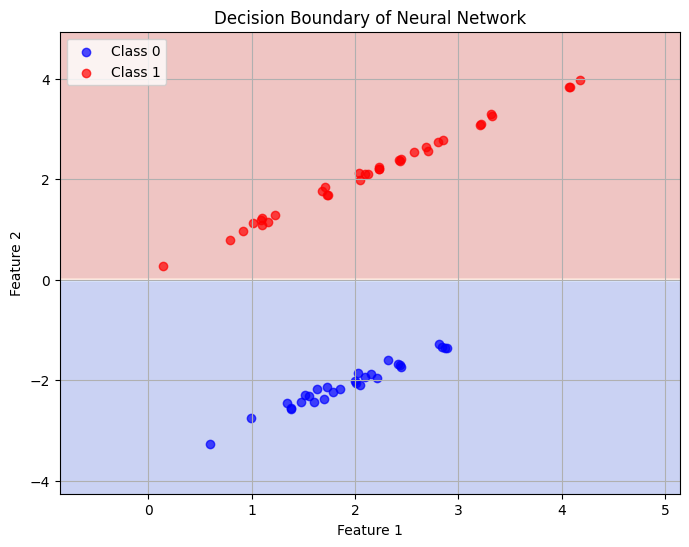

In [6]:
plot_decision_boundary_nn(X_train, y_train, layers, activation_funcs)

# Scikit learn on perfectly separated classes


Final accuracy on validation set after training: 1.0000

Final Confusion Matrix on validation set:
[[8 0]
 [0 8]]


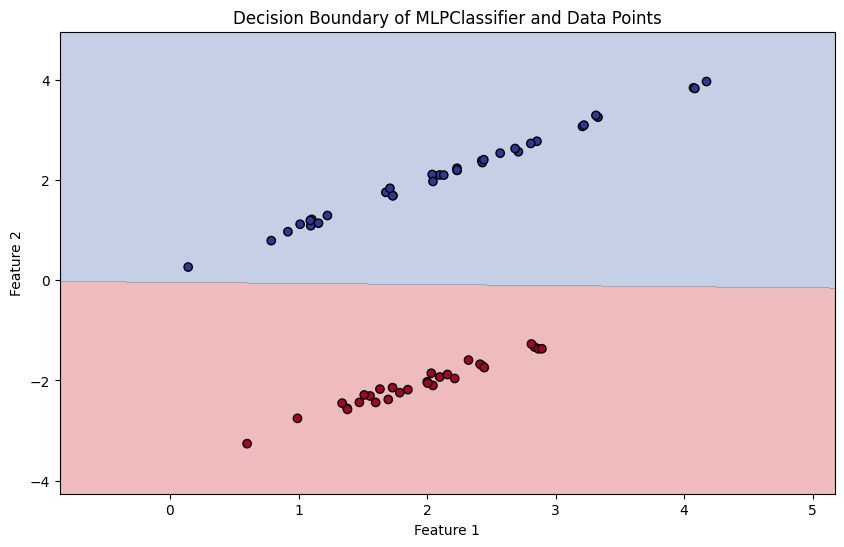

In [7]:
# Definizione del modello con architettura simile (8 neuroni nascosti e 2 neuroni di output con softmax)
mlp_clf = MLPClassifier(hidden_layer_sizes=(8,), activation='logistic', max_iter=1000, learning_rate_init=0.01, solver='sgd', random_state=32)

# Addestramento finale sul set di validazione
mlp_clf.fit(X_train, y_train)

# Previsioni finali sul set di validazione
final_predictions_val = mlp_clf.predict(X_val)
final_acc_val = accuracy_score(y_val, final_predictions_val)
print(f'\nFinal accuracy on validation set after training: {final_acc_val:.4f}')


# Confusion matrix
final_conf_matrix_val = confusion_matrix(y_val, final_predictions_val)
print("\nFinal Confusion Matrix on validation set:")
print(final_conf_matrix_val)

# Plotting the decision boundary for MLPClassifier
plot_mlp_decision_boundary_scikit(X_train, y_train, mlp_clf)


# Overlapping classes

In [8]:
np.random.seed(67)
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=32)

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert y_train and y_test to one-hot encoding
y_train_onehot = np.eye(2)[y_train]
y_val_onehot = np.eye(2)[y_val]

# Network configuration
input_size = X_train.shape[1]
layer_output_sizes = [8, 2]  # Output layer has 2 neurons for binary classification
activation_funcs = [sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der]

# Create layers
layers = create_layers_batch(input_size, layer_output_sizes)

# Get initial predictions and accuracy
initial_predictions = feed_forward_batch(X_val, layers, activation_funcs)
initial_pred_classes = np.argmax(initial_predictions, axis=1)  # Convert to class labels
initial_acc = accuracy_score(y_val, initial_pred_classes)
print(f'Initial accuracy before training: {initial_acc:.4f}')

# Confusion matrix before training
initial_conf_matrix = confusion_matrix(y_val, initial_pred_classes)
print("\nConfusion Matrix before training on validation:")
print(initial_conf_matrix)

# Train the network
layers, training_metrics, validation_metrics = train_nn_classification(X_train, y_train_onehot, X_val, y_val_onehot, layers, activation_funcs, activation_ders, learning_rate=0.01, epochs=1000, batch_size=32)

# Get final predictions and accuracy
final_predictions = feed_forward_batch(X_val, layers, activation_funcs)
final_pred_classes = np.argmax(final_predictions, axis=1)  
final_acc = accuracy_score(y_val, final_pred_classes)
print(f'\nFinal accuracy after training on validation: {final_acc:.4f}')

# Confusion matrix after training
final_conf_matrix = confusion_matrix(y_val, final_pred_classes)
print("\nConfusion Matrix after training on validation:")
print(final_conf_matrix)

Initial accuracy before training: 0.2500

Confusion Matrix before training on validation:
[[4 3]
 [9 0]]
Epoch 0, Training Accuracy: 0.0625
Epoch 100, Training Accuracy: 0.4375
Epoch 200, Training Accuracy: 0.5000
Epoch 300, Training Accuracy: 0.6250
Epoch 400, Training Accuracy: 0.6875
Epoch 500, Training Accuracy: 0.7188
Epoch 600, Training Accuracy: 0.7344
Epoch 700, Training Accuracy: 0.7656
Epoch 800, Training Accuracy: 0.7812
Epoch 900, Training Accuracy: 0.8125
Epoch 1000, Training Accuracy: 0.8281

Final accuracy after training on validation: 0.9375

Confusion Matrix after training on validation:
[[6 1]
 [0 9]]


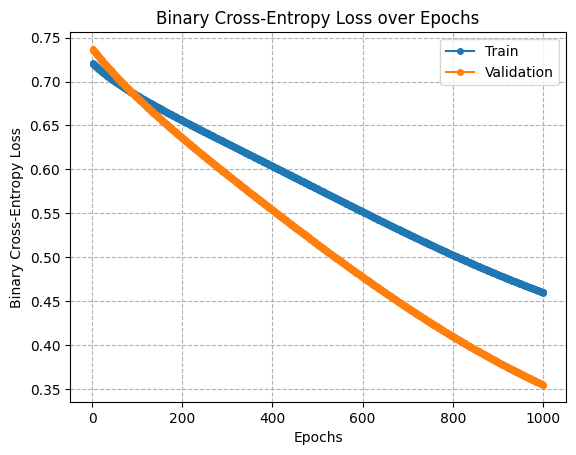

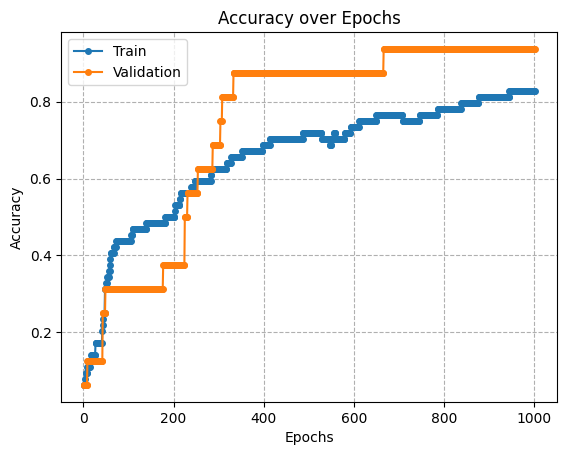

In [9]:
# Plot training and validation loss
plt.plot(range(1, len(training_metrics['loss']) + 1), training_metrics['loss'], label='Train', marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics['loss']) + 1), validation_metrics['loss'], label='Validation', marker='o', markersize=4)
plt.title('Binary Cross-Entropy Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, len(training_metrics['accuracy']) + 1), training_metrics['accuracy'], label='Train', marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics['accuracy']) + 1), validation_metrics['accuracy'], label='Validation', marker='o', markersize=4)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

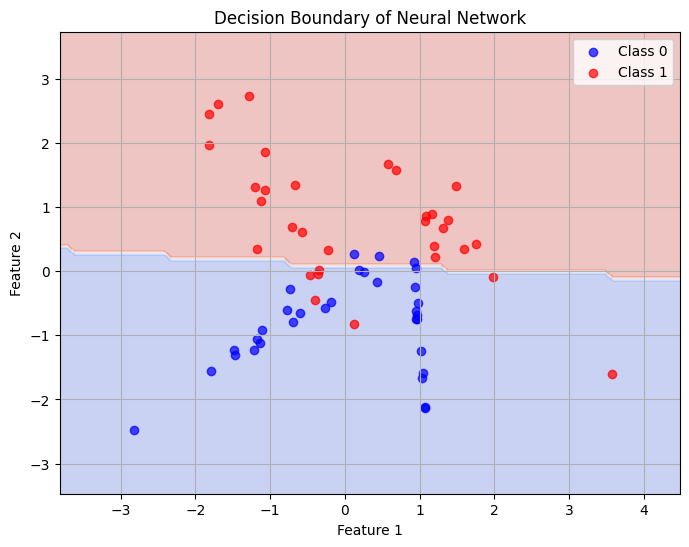

In [10]:
plot_decision_boundary_nn(X_train, y_train, layers, activation_funcs)

# Scikit-learn


Final accuracy on validation set after training: 0.9375

Final Confusion Matrix on validation set:
[[6 1]
 [0 9]]


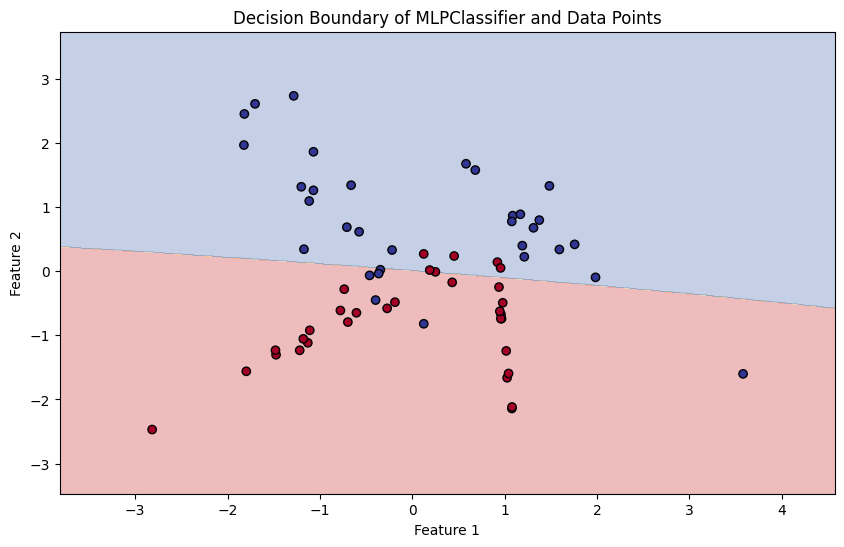

In [11]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(8,), activation='logistic', max_iter=1000, learning_rate_init=0.01, solver='sgd', random_state=32)

mlp_clf.fit(X_train, y_train)

final_predictions_val = mlp_clf.predict(X_val)
final_acc_val = accuracy_score(y_val, final_predictions_val)
print(f'\nFinal accuracy on validation set after training: {final_acc_val:.4f}')

# Confusion matrix
final_conf_matrix_val = confusion_matrix(y_val, final_predictions_val)
print("\nFinal Confusion Matrix on validation set:")
print(final_conf_matrix_val)

# Plotting the decision boundary for MLPClassifier
plot_mlp_decision_boundary_scikit(X_train, y_train, mlp_clf)